# Setup

In [1]:
!pip install -q nnsight seaborn

In [2]:
from nnsight import LanguageModel, CONFIG
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch as th
import torch  # for those who are afraid of th
import numpy as np
import pandas as pd
import json
from transformers import StoppingCriteria
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from pathlib import Path
from time import time
import itertools
from dataclasses import dataclass
from warnings import warn

th.set_grad_enabled(False)
import os

# os.environ["HF_TOKEN"] = "HF_TOKEN"
# CONFIG.set_default_api_key("nnkey")

# Utils

In [3]:
from IPython.display import Markdown, display


@dataclass
class Config:
    remote: bool = False
    max_batch_size: int = 64


config = Config()


def displaymd(string):
    display(
        Markdown(string.replace("<s>", "<‎s>"))
    )  # Little hack to prevent <s> from being interpreted as the html tag for strikethrough


class StopOnTokens(StoppingCriteria):
    def __init__(self, stop_tokens):
        """
        Args:
            stop_tokens (int or List[int]): The token(s) to stop generation at.
        """
        if isinstance(stop_tokens, int):
            stop_tokens = [stop_tokens]
        self.stop_tokens = stop_tokens

    def __call__(self, input_ids, _scores, **_kwargs):
        if input_ids[0][-1] in self.stop_tokens:
            return True  # Stop generation
        return False  # Continue generation

    def __len__(self):
        return 1

    def __iter__(self):
        yield self

    def from_string(string, tokenizer):
        """
        Initialize the stop tokens as all the tokens that start or end with the given string.
        """
        stop_tokens = [
            i
            for i in range(tokenizer.vocab_size)
            if tokenizer.decode(i).startswith(string)
            or tokenizer.decode(i).endswith(string)
            or string in tokenizer.decode(i)
        ]
        return StopOnTokens(stop_tokens)


class StopOnSequence(StoppingCriteria):
    def __init__(self, stop_sequence):
        """
        Args:
            stop_sequence (List[int]): The sequence to stop generation at.
        """
        self.stop_sequence = stop_sequence
        self.state = 0

    def __call__(self, input_ids, _scores, **_kwargs):
        if input_ids[0][-1] == self.stop_sequence[self.state]:
            self.state += 1
            if self.state == len(self.stop_sequence):
                return True
        else:
            self.state = 0
        return False

    def __len__(self):
        return 1

    def __iter__(self):
        yield self

    def from_string(string, tokenizer):
        """
        Initialize the stop tokens as all the tokens that start or end with the given string.
        """
        stop_sequence = [tokenizer(string, add_special_tokens=False)]
        return StopOnSequence(stop_sequence)

In [4]:
def plot_topk(probs, nn_model, k=4, title=None, dynamic_size=True, use_token_ids=False):
    """
    Plot the top k tokens for each layer
    :param probs: Probability tensor of shape (num_layers, vocab_size)
    :param k: Number of top tokens to plot
    :param title: Title of the plot
    :param dynamic_size: If True, the size of the plot will be adjusted based on the length of the tokens
    """
    num_layers = len(nn_model.model.layers)
    top_tokens = th.topk(probs, k=k, dim=-1)
    top_probs = top_tokens.values
    if not use_token_ids:
        top_token_indices = [
            ["'" + nn_model.tokenizer.convert_ids_to_tokens(t.item()) + "'" for t in l]
            for l in top_tokens.indices
        ]
    else:
        top_token_indices = [[str(t.item()) for t in l] for l in top_tokens.indices]
    cmap = sns.diverging_palette(255, 0, as_cmap=True)
    max_token_length = max(
        [len(token) for sublist in top_token_indices for token in sublist]
    )
    if dynamic_size:
        plt.figure(figsize=(max_token_length * k * 0.25, num_layers / 2))
    else:
        plt.figure(figsize=(15, 10))
    ax = sns.heatmap(
        top_probs.detach().numpy(),
        annot=top_token_indices,
        fmt="",
        cmap=cmap,
        linewidths=0.5,
        cbar_kws={"label": "Probability"},
    )
    if title is None:
        plt.title(f"Top {k} Tokens Heatmap")
    else:
        plt.title(f"Top {k} Tokens Heatmap - {title}")
    plt.xlabel("Tokens")
    plt.ylabel("Layers")

    plt.yticks(np.arange(num_layers) + 0.5, range(num_layers))

    # plt.tight_layout()  # Adjust subplot parameters to fit the figure area
    plt.show()


def display_generations_md(nn_model, prompts, gen_strings: dict, replace_str=None):
    if isinstance(prompts, str):
        prompts = [prompts]
    md_strings = []

    def preprocess(s):
        if replace_str is not None:
            return s.replace(replace_str, "[[REPLACED]]")
        return s

    for i, prompt in enumerate(prompts):
        prompt = prompt.replace("\n", "\n\n")
        md_strings.append(f"**Prompt:** {prompt}")
        for k, v in gen_strings.items():
            gen = nn_model.tokenizer.decode(v[i])
            md_strings.append(
                f"- **Layer {k}:**<br>\n" + f"```\n{preprocess(gen)}\n```"
            )
        md_strings.append("\n")
    out = "\n".join(md_strings)
    displaymd(out)


def generations_to_table(nn_model, prompts, gen_strings: dict, replace_str=None):
    if isinstance(prompts, str):
        prompts = [prompts]
    df = pd.DataFrame({"Prompt": prompts})

    def preprocess(s):
        if replace_str is not None:
            return s.replace(replace_str, "[[REPLACED]]")
        return s

    dic = {
        f"Layer {k}": [preprocess(nn_model.tokenizer.decode(v)) for v in gen_strings[k]]
        for k in gen_strings
    }
    dflayer = pd.DataFrame(dic)
    df = pd.concat([df, dflayer], axis=1)
    df.style.hide(axis="index")
    return df


def display_generations_table(nn_model, prompts, gen_strings: dict, replace_str=None):
    df = generations_to_table(nn_model, prompts, gen_strings, replace_str)
    # fmt: off
    with pd.option_context(
        "display.max_colwidth", None,
        "display.max_columns", None,
        "display.max_rows", None,
    ):
        display(df)
    # fmt: on

# Patchscope & logit lens

In [5]:
def logit_lens(nn_model: LanguageModel, prompts: list[str] | str, scan=True):
    """
    Same as logit_lens but for Llama models directly instead of Transformer_lens models.
    Get the probabilities of the next token for the last token of each prompt at each layer using the logit lens.

    Args:
        nn_model: NNSight LanguageModel object
        prompts: List of prompts or a single prompt

    Returns:
        A tensor of shape (num_prompts, num_layers, vocab_size) containing the probabilities
        of the next token for each prompt at each layer. Tensor is on the CPU.
    """
    remote = config.remote
    nn_model.eval()
    tok_prompts = nn_model.tokenizer(prompts, return_tensors="pt", padding=True)
    # Todo?: This is a hacky way to get the last token index but it works for both left and right padding
    last_token_index = (
        tok_prompts.attention_mask.flip(1).cumsum(1).bool().int().sum(1).sub(1)
    )
    with nn_model.trace(prompts, scan=scan, remote=remote) as tracer:
        hiddens_l = [
            layer.output[0][
                th.arange(len(tok_prompts.input_ids)),
                last_token_index,
            ]
            for layer in nn_model.model.layers
        ]
        probs_l = []
        for hiddens in hiddens_l:
            ln_out = nn_model.model.norm(hiddens)
            logits = nn_model.lm_head(ln_out)
            probs = logits.softmax(-1).cpu()
            probs_l.append(probs)
        probs = th.stack(probs_l).transpose(0, 1).save()
    return probs

In [34]:
@dataclass
class PatchScopePrompt:
    prompt: str
    index_to_patch: int


@th.no_grad
def patchscope_lens(
    nn_model: LanguageModel,
    prompts: list[str] | str,
    patch_prompt: PatchScopePrompt,
    scan=True,
):
    """
    Replace the hidden state of the patch_prompt.index_to_patch token in the patch_prompt.prompt with the hidden state of the last token of each prompt at each layer.
    Returns the probabilities of the next token in patch_prompt for each prompt for each layer intervention.
    Args:
        nn_model: The NNSight LanguageModel with llama architecture
        prompts: List of prompts or a single prompt to get the hidden states of the last token
        patch_prompt: A PatchScopePrompt object containing the prompt to patch and the index of the token to patch
        scan: If looping over this function, set to False after the first call to speed up subsequent calls
        remote: If True, the function will run on the nndif server. See `nnsight.net/status` to check which models are available.
    Returns:
        A tensor of shape (num_prompts, num_layers, vocab_size) containing the probabilities
        of the next token for each prompt at each layer. Tensor is on the CPU.
    """
    remote = config.remote
    nn_model.eval()
    tok_prompts = nn_model.tokenizer(prompts, return_tensors="pt", padding=True)
    # Todo?: This is a hacky way to get the last token index but it works for both left and right padding
    last_token_index = (
        tok_prompts.attention_mask.flip(1).cumsum(1).bool().int().sum(1).sub(1)
    )
    # Collect the hidden states of the last token of each prompt at each layer
    if isinstance(prompts, str):
        prompts = [prompts]
    probs_l = []
    with nn_model.trace(prompts, scan=scan, remote=remote) as tracer:
        hiddens = [
            layer.output[0][
                th.arange(len(tok_prompts.input_ids)),
                last_token_index,
            ].save()
            for layer in nn_model.model.layers
        ]
        # For each prompt, we will do n_layers patching so we need to expand the cache accordingly
    n_layers = len(nn_model.model.layers)
    # Collect the patch activations for each prompt at each layer
    for layer in range(n_layers):
        with nn_model.trace(
            [patch_prompt.prompt] * len(prompts),
            scan=layer == 0,
            remote=remote,
        ):
            nn_model.model.layers[layer].output[0][:, patch_prompt.index_to_patch] = (
                hiddens[layer]
            )
            output = nn_model.lm_head.output
            probs = output[:, -1, :].softmax(-1).cpu().save()
            probs_l.append(probs)
    probs = th.cat(probs_l, dim=0)
    return probs.reshape(n_layers, len(prompts), -1).transpose(0, 1)


@th.no_grad
def patchscope_generate(
    nn_model: LanguageModel,
    prompts: list[str] | str,
    patch_prompt: PatchScopePrompt,
    max_length=50,
    layers=None,
    stopping_criteria=None,
    scan=True,
):
    """
    Replace the hidden state of the patch_prompt.index_to_patch token in the patch_prompt.prompt with the hidden state of the last token of each prompt at each layer.
    Returns the probabilities of the next token in patch_prompt for each prompt for each layer intervention.
    Args:
        nn_model: The NNSight LanguageModel with llama architecture
        prompts: List of prompts or a single prompt to get the hidden states of the last token
        patch_prompt: A PatchScopePrompt object containing the prompt to patch and the index of the token to patch
        layers: List of layers to intervene on. If None, all layers are intervened on.
        stopping_criteria: The HF stopping criteria which stops generation when it is met for ALL prompts
        scan: If looping over this function, set to False after the first call to speed up subsequent calls
        remote: If True, the function will run on the nndif server. See `nnsight.net/status` to check which models are available.
        max_batch_size: The maximum number of prompts to intervene on at once.

    Returns:
        A tensor of shape (num_prompts, num_layers, vocab_size) containing the probabilities
        of the next token for each prompt at each layer. Tensor is on the CPU.
    """
    max_batch_size = config.max_batch_size
    if isinstance(prompts, str):
        prompts = [prompts]
    if len(prompts) > max_batch_size:
        warn(
            f"Number of prompts ({len(prompts)}) exceeds max_batch_size ({max_batch_size}). This may cause memory errors."
        )
    remote = config.remote
    nn_model.eval()
    n_layers = len(nn_model.model.layers)
    if layers is None:
        layers = list(range(n_layers))
    tok_prompts = nn_model.tokenizer(prompts, return_tensors="pt", padding=True)
    # Todo?: This is a hacky way to get the last token index but it works for both left and right padding
    last_token_index = (
        tok_prompts.attention_mask.flip(1).cumsum(1).bool().int().sum(1).sub(1)
    )
    # Collect the hidden states of the last token of each prompt at each layer
    with nn_model.trace(prompts, scan=scan, remote=remote):
        hiddens = [
            layer.output[0][
                th.arange(len(tok_prompts.input_ids)),
                last_token_index,
            ].save()
            for layer in nn_model.model.layers
        ]
    generations = {}
    gen_kwargs = dict(
        remote=remote, max_new_tokens=max_length, stopping_criteria=stopping_criteria
    )
    layer_loader = DataLoader(layers, batch_size=max(max_batch_size // len(prompts), 1))
    scan_once = True
    for layer_batch in layer_loader:
        print(f"Intervening on layers {layer_batch}, prompts {len(prompts)}")
        with nn_model.generate(**gen_kwargs) as tracer:
            for layer in layer_batch:
                layer = layer.item()
                with tracer.invoke(
                    [patch_prompt.prompt] * len(prompts), scan=(scan and scan_once)
                ):
                    nn_model.model.layers[layer].output[0][
                        :, patch_prompt.index_to_patch
                    ] = hiddens[layer]
                    gen = nn_model.generator.output.save()
                    generations[layer] = gen
                scan_once = False
    for k, v in generations.items():
        generations[k] = v.cpu()
    return generations

# Prompt Utils

In [13]:
def identity_prompt(
    nn_model=None, words=None, rel=" -> ", sep="\n", placeholder="?"
) -> PatchScopePrompt:
    """
    Prompt used in the patchscopes paper to predict the next token.
    https://github.com/PAIR-code/interpretability/blob/master/patchscopes/code/next_token_prediction.ipynb
    """
    if words is None:
        words = ["cat", "1135", "hello"]
    assert nn_model is None or (
        len(nn_model.tokenizer.tokenize(placeholder)) == 1
    ), "Using a placeholder that is not a single token sounds like a bad idea"
    prompt = sep.join([w + rel + w for w in words]) + sep + placeholder
    index_to_patch = -1
    return PatchScopePrompt(prompt, index_to_patch)


def description_prompt(placeholder="?"):
    return PatchScopePrompt(
        f"""Jensen Huang is the CEO of NVIDIA, a technology company
New York City is the largest city in the United States
Johnny Depp is a famous actor known for his role in Pirates of the Caribbean
Google is a technology company known for its search engine
Ariana Grande is a famous singer from the United States
Sam Altman is the CEO of OpenAI, a research lab focused on artificial intelligence
The Eiffel Tower is a famous landmark in Paris, France
C++ is a programming language known for its speed and performance
A spoon is a utensil used for eating food
{placeholder}""",
        -1,
    )


example = identity_prompt()
displaymd(
    f"**Prompt:**\n```\n{example.prompt}\n```\n**Index to patch:** {example.index_to_patch}"
)

**Prompt:**
```
cat -> cat
1135 -> 1135
hello -> hello
?
```
**Index to patch:** -1

# Playground

In [14]:
es_de_prompt = """Español: "rojo" - Deutsch: "rot"
Español: "mano" - Deutsch: "Hand"
Español: "grupo" - Deutsch: "Gruppe"
Español: "estrella" - Deutsch: "Stern"
Español: "puente" - Deutsch: "Brücke"
Español: "gato" - Deutsch: \""""
fr_en_prompt = """Français: "rouge" - English: "red"
Français: "main" - English: "hand"
Français: "groupe" - English: "group"
Français: "étoile" - English: "star"
Français: "pont" - English: "bridge"
Français: "chat" - English: \""""
es_fr_prompt = """Español: "rojo" - Français: "rouge"
Español: "mano" - Français: "main"
Español: "grupo" - Français: "groupe"
Español: "estrella" - Français: "étoile"
Español: "puente" - Français: "pont"
Español: "gato" - Français: \""""

In [15]:
llama_like = "meta-llama/Llama-2-70b-hf"
config.remote = True
config.max_batch_size = 16
# llama_like = "croissantllm/croissantllmbase"; config.remote=False
nn_model = LanguageModel(llama_like, device_map="auto")

# Usage example

## Logit lens on a translation

6644c950002c2d9aa91d051b - RECEIVED: Your job has been received and is waiting approval.
6644c950002c2d9aa91d051b - APPROVED: Your job was approved and is waiting to be run.
6644c950002c2d9aa91d051b - COMPLETED: Your job has been completed.


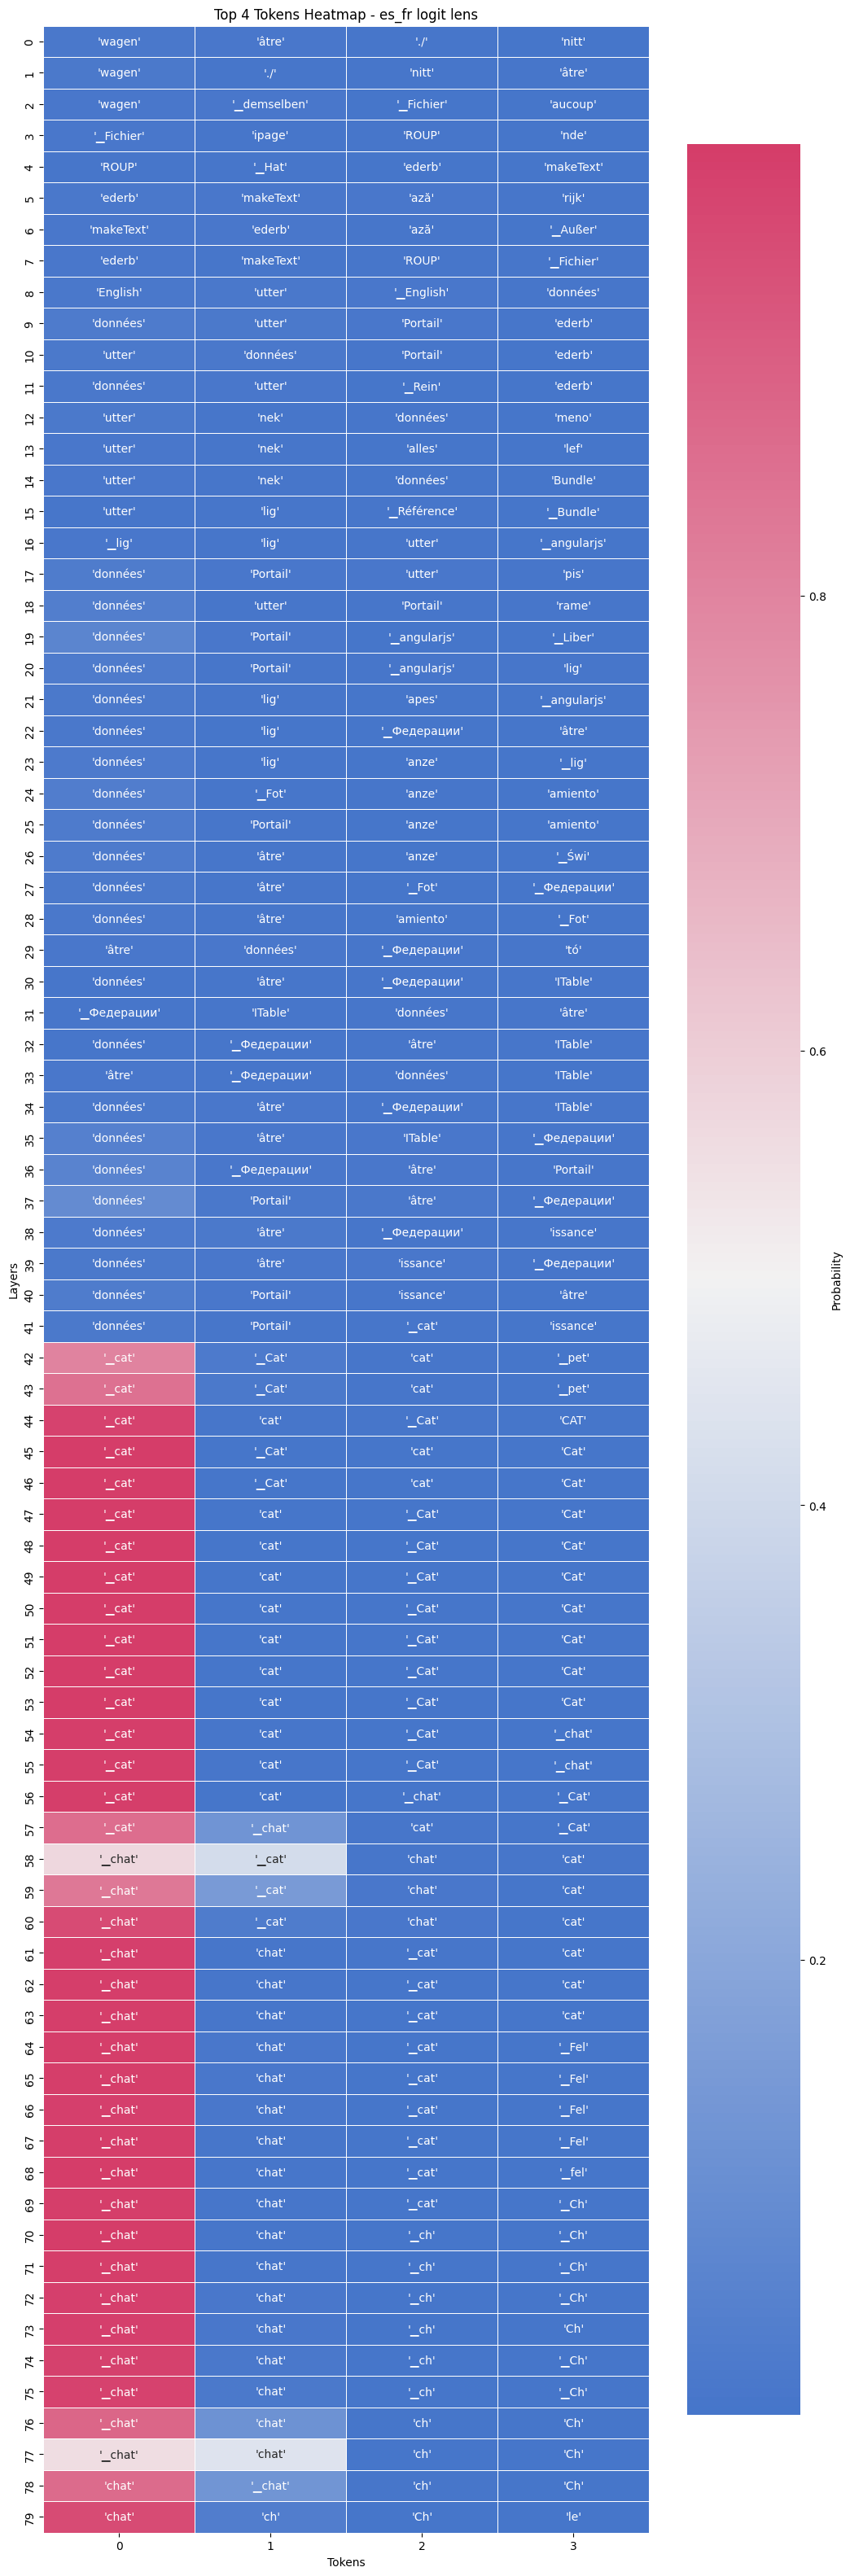

In [16]:
probs = logit_lens(nn_model, [es_de_prompt, fr_en_prompt, es_fr_prompt])
plot_topk(probs[2], nn_model, k=4, title="es_fr logit lens")

## Patchscoping

### Generation with repition task

In [22]:
patch_prompt = identity_prompt(nn_model)
patch_gen = patchscope_generate(
    nn_model, fr_en_prompt, patch_prompt, layers=[0, 5, 10, 15, 20]
)

6644c9ee002c2d9aa91d051c - RECEIVED: Your job has been received and is waiting approval.
6644c9ee002c2d9aa91d051c - APPROVED: Your job was approved and is waiting to be run.
6644c9ee002c2d9aa91d051c - COMPLETED: Your job has been completed.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Intervening on layers tensor([0]), prompts 1
6644c9f5b78a3a8142a1901d - RECEIVED: Your job has been received and is waiting approval.
6644c9f5b78a3a8142a1901d - APPROVED: Your job was approved and is waiting to be run.
6644c9f5b78a3a8142a1901d - COMPLETED: Your job has been completed.


Intervening on layers tensor([5]), prompts 1
6644ca0ab6a68fc7ea14bb40 - RECEIVED: Your job has been received and is waiting approval.
6644ca0ab6a68fc7ea14bb40 - APPROVED: Your job was approved and is waiting to be run.
6644ca0ab6a68fc7ea14bb40 - COMPLETED: Your job has been completed.


Intervening on layers tensor([10]), prompts 1
6644ca1bb6a68fc7ea14bb41 - RECEIVED: Your job has been received and is waiting approval.
6644ca1bb6a68fc7ea14bb41 - APPROVED: Your job was approved and is waiting to be run.
6644ca1bb6a68fc7ea14bb41 - COMPLETED: Your job has been completed.


Intervening on layers tensor([15]), prompts 1
6644ca2e875e942aa172bf6c - RECEIVED: Your job has been received and is waiting approval.
6644ca2e875e942aa172bf6c - APPROVED: Your job was approved and is waiting to be run.
6644ca2e875e942aa172bf6c - COMPLETED: Your job has been completed.


Intervening on layers tensor([20]), prompts 1
6644ca3f875e942aa172bf6d - RECEIVED: Your job has been received and is waiting approval.
6644ca3f875e942aa172bf6d - APPROVED: Your job was approved and is waiting to be run.
6644ca3f875e942aa172bf6d - COMPLETED: Your job has been completed.


In [23]:
display_generations_table(nn_model, fr_en_prompt, patch_gen)

,Prompt,Layer 0,Layer 5,Layer 10,Layer 15,Layer 20
0,"Français: ""rouge"" - English: ""red""\nFrançais: ""main"" - English: ""hand""\nFrançais: ""groupe"" - English: ""group""\nFrançais: ""étoile"" - English: ""star""\nFrançais: ""pont"" - English: ""bridge""\nFrançais: ""chat"" - English: ""","<s> cat -> cat\n1135 -> 1135\nhello -> hello\n?hello"" -> ""hello""\n""hello"" -> ""hello""\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n","<s> cat -> cat\n1135 -> 1135\nhello -> hello\n?hello"" -> ""hello""\n""hello"" -> ""hello""\n""hello"" -> ""hello""\n""hello"" -> ""hello""\n""hello"" -> ""hello""\n""hello"" -> ""hello""\n""hello""","<s> cat -> cat\n1135 -> 1135\nhello -> hello\n?hello"" -> ""hello""\n""hello"" -> ""hello""\n""hello"" -> ""hello""\n""hello"" -> ""hello""\n""hello"" -> ""hello""\n""hello"" -> ""hello""\n""hello""",<s> cat -> cat\n1135 -> 1135\nhello -> hello\n?hello -> hello\nhello world -> hello world\nhello world -> hello world\nhello world -> hello world\nhello world -> hello world\nhello world -> hello world\nhello world -> hello world\nhello world -> hello world\nhello world -> hello,<s> cat -> cat\n1135 -> 1135\nhello -> hello\n?hello -> hello\nhello world -> hello world\nhello world -> hello world\nhello world -> hello world\nhello world -> hello world\nhello world -> hello world\nhello world -> hello world\nhello world -> hello world\nhello world -> hello


In [24]:
display_generations_md(nn_model, fr_en_prompt, patch_gen)

**Prompt:** Français: "rouge" - English: "red"

Français: "main" - English: "hand"

Français: "groupe" - English: "group"

Français: "étoile" - English: "star"

Français: "pont" - English: "bridge"

Français: "chat" - English: "
- **Layer 0:**<br>
```
<‎s> cat -> cat
1135 -> 1135
hello -> hello
?hello" -> "hello"
"hello" -> "hello"




































```
- **Layer 5:**<br>
```
<‎s> cat -> cat
1135 -> 1135
hello -> hello
?hello" -> "hello"
"hello" -> "hello"
"hello" -> "hello"
"hello" -> "hello"
"hello" -> "hello"
"hello" -> "hello"
"hello"
```
- **Layer 10:**<br>
```
<‎s> cat -> cat
1135 -> 1135
hello -> hello
?hello" -> "hello"
"hello" -> "hello"
"hello" -> "hello"
"hello" -> "hello"
"hello" -> "hello"
"hello" -> "hello"
"hello"
```
- **Layer 15:**<br>
```
<‎s> cat -> cat
1135 -> 1135
hello -> hello
?hello -> hello
hello world -> hello world
hello world -> hello world
hello world -> hello world
hello world -> hello world
hello world -> hello world
hello world -> hello world
hello world -> hello world
hello world -> hello
```
- **Layer 20:**<br>
```
<‎s> cat -> cat
1135 -> 1135
hello -> hello
?hello -> hello
hello world -> hello world
hello world -> hello world
hello world -> hello world
hello world -> hello world
hello world -> hello world
hello world -> hello world
hello world -> hello world
hello world -> hello
```



### Generation with description task

In [47]:
from nnsight import LanguageModel
from transformers import StoppingCriteria

class Stopping(StoppingCriteria):
    def __init__(self):
        pass

    def __call__(self, input_ids, _scores, **_kwargs):
        return False  # Continue generation

    def __len__(self):
        return 1

    def __iter__(self):
        yield self

nn_model = LanguageModel("meta-llama/Llama-2-70b-hf")

stopping_criteria = Stopping()
with nn_model.generate("hello", remote=True, stopping_criteria=stopping_criteria) as tracer:
    out = nn_model.generator.output.save()
print(nn_model.tokenizer.decode(out[0]))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


TypeError: object of type 'StoppingCriteria' has no len()

In [44]:
config.max_batch_size = 64
patch_prompt = description_prompt()
# jeff = "This is an interview with the CEO of Amazon"
stopping_criteria = StopOnTokens.from_string("\n", nn_model.tokenizer)
jeff = "Jeff Bezos"
patch_gen = patchscope_generate(
    nn_model,
    jeff,
    PatchScopePrompt("?:", 0),
    # stopping_criteria=stopping_criteria
    # layers=list(range(len(nn_model.model.layers))),
)
display_generations_table(
    nn_model, jeff, patch_gen, replace_str=patch_prompt.prompt[:-2]
)

6644e2f5875e942aa172bfc4 - RECEIVED: Your job has been received and is waiting approval.
6644e2f5875e942aa172bfc4 - APPROVED: Your job was approved and is waiting to be run.
6644e2f5875e942aa172bfc4 - COMPLETED: Your job has been completed.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Intervening on layers tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63]), prompts 1
6644e300ba4b3e26c92ad89f - RECEIVED: Your job has been received and is waiting approval.
6644e300ba4b3e26c92ad89f - APPROVED: Your job was approved and is waiting to be run.
6644e300ba4b3e26c92ad89f - COMPLETED: Your job has been completed.


Intervening on layers tensor([64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]), prompts 1
6644e32d875e942aa172bfc5 - RECEIVED: Your job has been received and is waiting approval.
6644e32d875e942aa172bfc5 - APPROVED: Your job was approved and is waiting to be run.
6644e32d875e942aa172bfc5 - COMPLETED: Your job has been completed.


,Prompt,Layer 0,Layer 1,Layer 2,Layer 3,Layer 4,Layer 5,Layer 6,Layer 7,Layer 8,Layer 9,Layer 10,Layer 11,Layer 12,Layer 13,Layer 14,Layer 15,Layer 16,Layer 17,Layer 18,Layer 19,Layer 20,Layer 21,Layer 22,Layer 23,Layer 24,Layer 25,Layer 26,Layer 27,Layer 28,Layer 29,Layer 30,Layer 31,Layer 32,Layer 33,Layer 34,Layer 35,Layer 36,Layer 37,Layer 38,Layer 39,Layer 40,Layer 41,Layer 42,Layer 43,Layer 44,Layer 45,Layer 46,Layer 47,Layer 48,Layer 49,Layer 50,Layer 51,Layer 52,Layer 53,Layer 54,Layer 55,Layer 56,Layer 57,Layer 58,Layer 59,Layer 60,Layer 61,Layer 62,Layer 63,Layer 64,Layer 65,Layer 66,Layer 67,Layer 68,Layer 69,Layer 70,Layer 71,Layer 72,Layer 73,Layer 74,Layer 75,Layer 76,Layer 77,Layer 78,Layer 79
0,Jeff Bezos,<s> ?:\n\n\begin{code}\n<?php\n\n$a = 1;\n$b = 2;\n$c = 3;\n\n$d = $a ?: $b ?: $c;\n\n,"<s> ?:\n\n\begin{code}\n<script src=""https://ajax.googleapis.com/ajax/libs/jquery/3.3.1/jquery.min.js""></script>\n<script src=""https://maxcdn.","<s> ?:\n\n* 1998: 1 BK AC - 13,40\n* 1999: 1 BK AC - 13,3\n* 2000:",<s> ?:\n\n\begin{code}\n\n\begin{code}\n\n\begin{code}\n\n\begin{code}\n\n\begin{code}\n\n\begin{code}\n\n\begin{code}\n,<s> ?:\n\n\begin{code}\n public class MyCustomAdapter extends ArrayAdapter<MyCustomObject> {\n\n private Context context;\n private List<MyCustomObject> objects;\n\n public MyCustomAdapter(Context,<s> ?:\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n,<s> ?:\\\\ll'll be a lot of the thellmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâ,<s> ?:âââââââââââââââââââââââââââââââââââââââââ\\ââââââââ,<s> ?:âmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâm,<s> ?:âmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâmâm,<s> ?:ââââââââââââââââââââââââââââââââââââââââââââââââââ,<s> ?:ÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃ,<s> ?:ÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃ,<s> ?:ÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃ,<s> ?:ÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃÃ,<s> ?:\\t:\\t:\\t:\\t:\\t:\\t:\\t:\\t:\\t:\\t:\\t:\\t:\\t:\\t:\\t:\\t:\\t,<s> ?: 1111 11 10 10 10 10 10 10 10 10 10 10 10 10 10 10,<s> ?:\\ing:\\ing:\\ing:\\ing:\\ing:\\ing:\\ing:\\ing:\\ing:\\ing:\\ing:\\ing:\\ing:\\ing:\\ing:\\ing:\\ing,<s> ?: 1000 1000 1000 1000 1000 1000 1000 1000 1000 100,<s> ?: 1111 111 1 100 100 100 100 100 100 100 100 100 10,<s> ?:\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\\ing the\n\n\\ing the\n\n\\ing the\n\n\\ing the\n\n\\ing the\n\n\\ing the\n\n\\ing the\n,<s> ?:\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\\\n\n\n\\\n\n\n\n\\\n\n\\\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\\\n\n\n\n,<s> ?:\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\,<s> ?:\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\,<s> ?:\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\,<s> ?:\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\,<s> ?:\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\,<s> ?:\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\,<s> ?:\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\,<s> ?:\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\,<s> ?:llllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll,<s> ?:llllllLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL,<s> ?:aaaallllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll,<s> ?:aaaallllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll,<s> ?:aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

In [42]:
config.max_batch_size = 1
patch_prompt = description_prompt()
# jeff = "This is an interview with the CEO of Amazon"
jeff = "Jeff Bezos"
stopping_criteria = StopOnTokens.from_string("\n", nn_model.tokenizer)
patch_gen = patchscope_generate(
    nn_model, jeff, patch_prompt, stopping_criteria=stopping_criteria
)
display_generations_table(
    nn_model, jeff, patch_gen, replace_str=patch_prompt.prompt[:-2]
)

6644e2ceb6a68fc7ea14bb61 - RECEIVED: Your job has been received and is waiting approval.
6644e2ceb6a68fc7ea14bb61 - APPROVED: Your job was approved and is waiting to be run.
6644e2ceb6a68fc7ea14bb61 - COMPLETED: Your job has been completed.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Intervening on layers tensor([0]), prompts 1


RecursionError: maximum recursion depth exceeded

### Patchscope plots with variants of identity prompt

PatchScopePrompt(prompt='cat -> cat\n1135 -> 1135\nhello -> hello\n?', index_to_patch=-1)


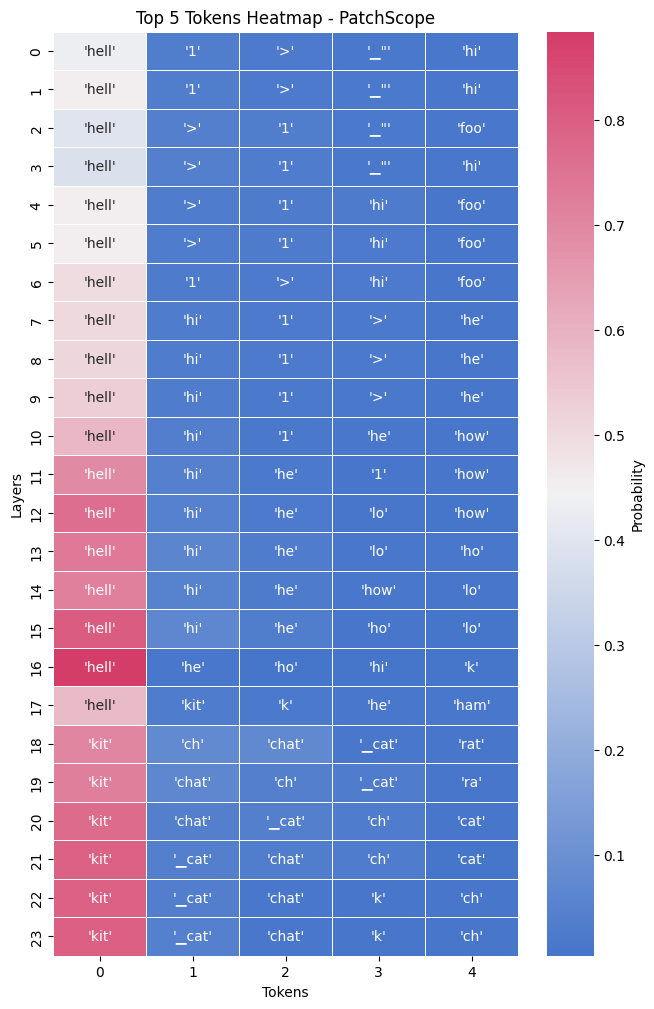

In [ ]:
patch_prompt = identity_prompt(nn_model)
print(patch_prompt)
patch_probs = patchscope_lens(nn_model, fr_en_prompt, patch_prompt)
plot_topk(patch_probs[0], nn_model, k=5, title="PatchScope")

PatchScopePrompt(prompt='cat -> cat\n1135 -> 1135\nhello -> hello\n', index_to_patch=-1)


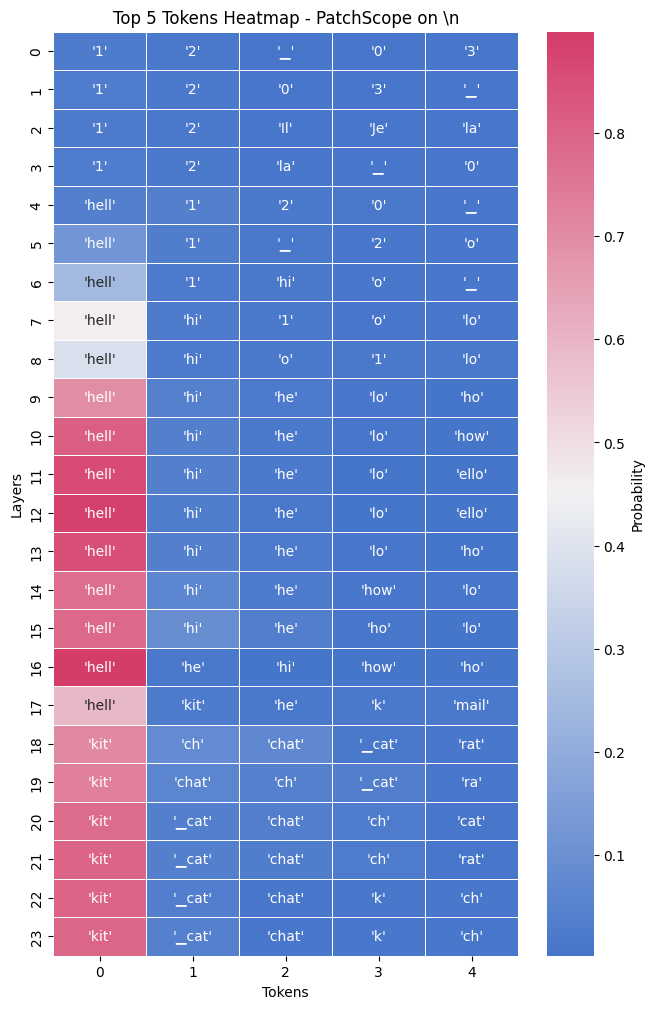

In [ ]:
patch_prompt = identity_prompt(nn_model)
patch_prompt.prompt = patch_prompt.prompt[:-1]
print(patch_prompt)
patch_probs = patchscope_lens(nn_model, fr_en_prompt, patch_prompt)
plot_topk(patch_probs[0], nn_model, k=5, title="PatchScope on \\n")

In [ ]:
patch_prompt = identity_prompt(nn_model)
patch_prompt.prompt = patch_prompt.prompt + " ->"
patch_prompt.index_to_patch = -len(nn_model.tokenizer.tokenize(" ->")) - 1
print(patch_prompt)
patch_probs = patchscope_lens(nn_model, fr_en_prompt, patch_prompt)
plot_topk(patch_probs[0], nn_model, k=5, title="PatchScope identity with ->")

PatchScopePrompt(prompt='cat -> cat\n1135 -> 1135\nhello -> hello\n? ->', index_to_patch=-3)
663a4288c3dbbeb91cf7c9c2 - RECEIVED: Your job has been received and is waiting approval.
663a4288c3dbbeb91cf7c9c2 - APPROVED: Your job was approved and is waiting to be run.


KeyboardInterrupt: 

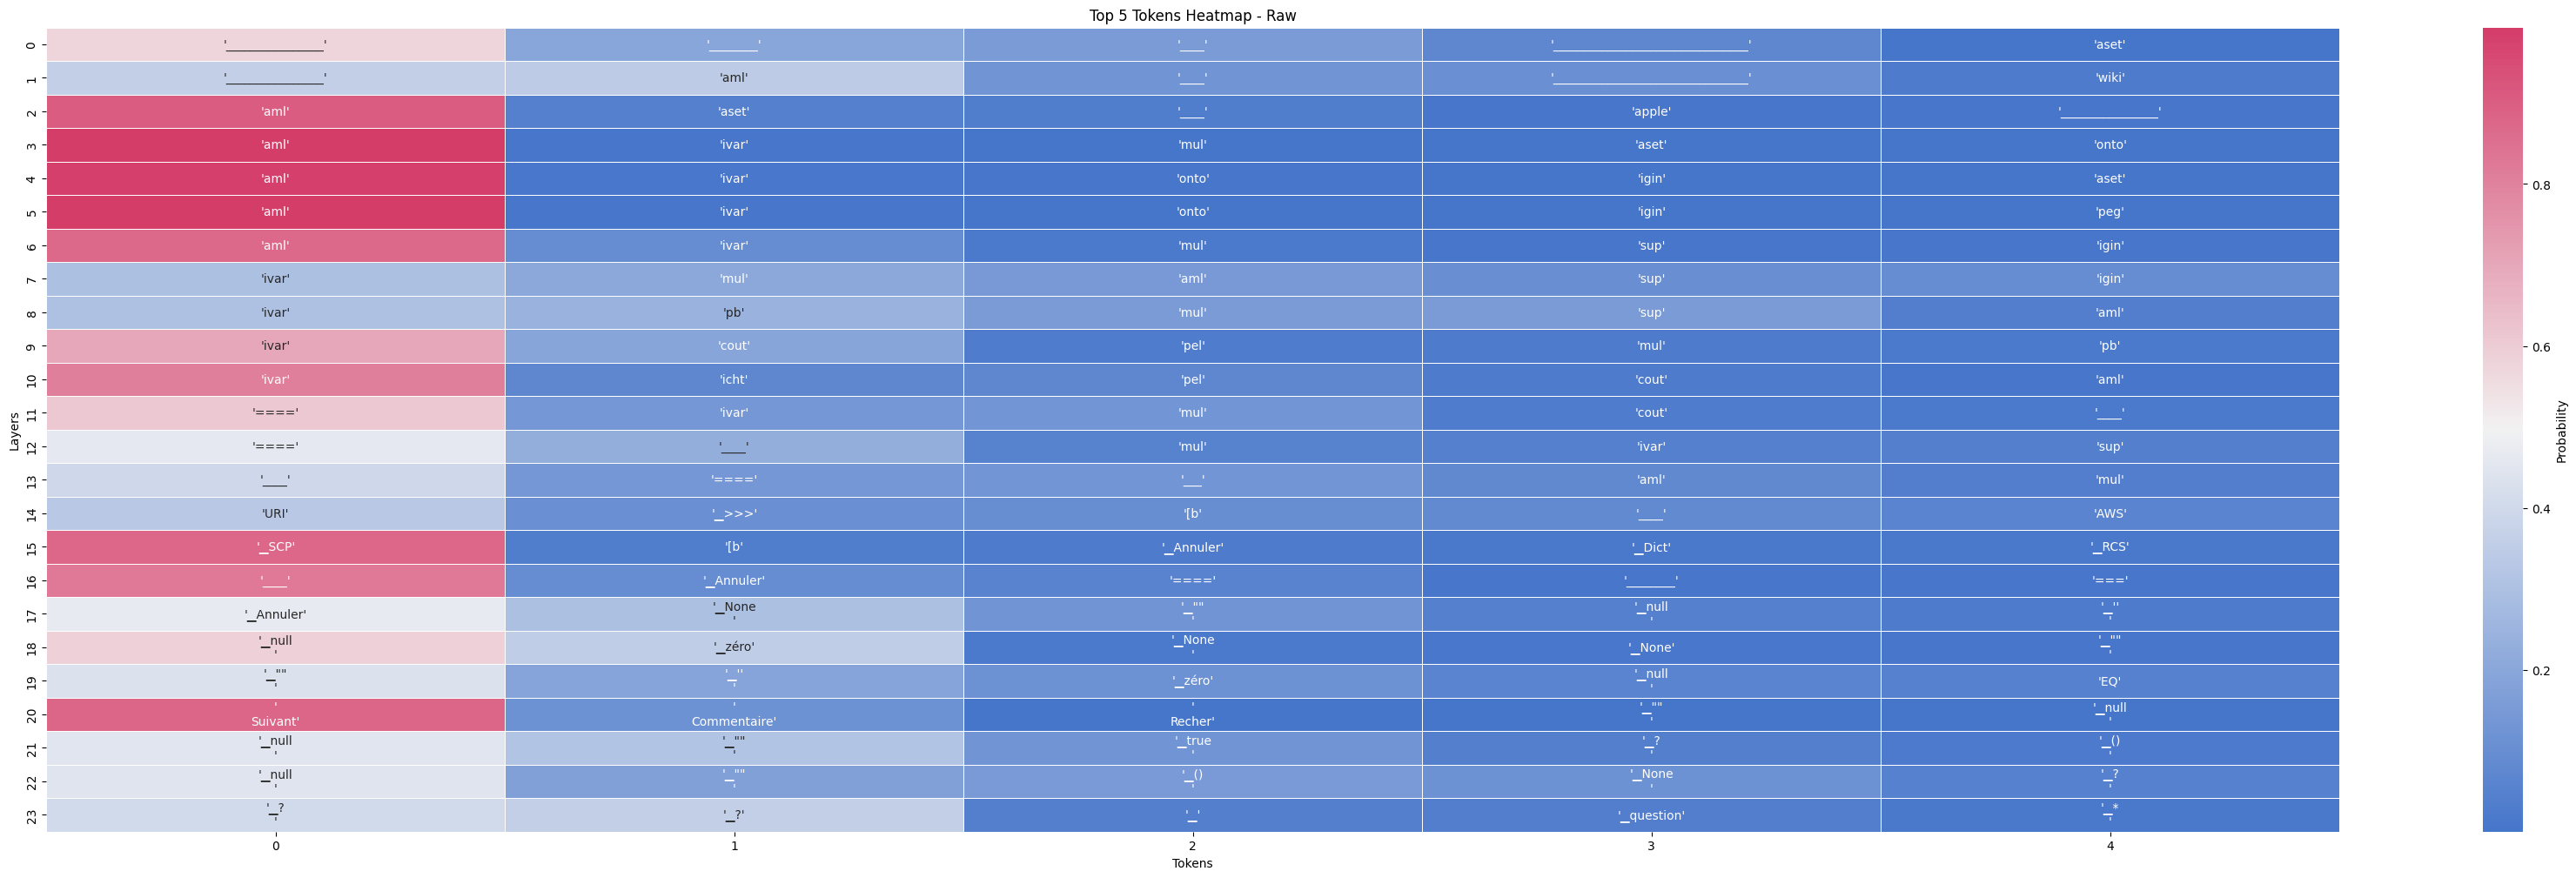

In [ ]:
raw_probs = logit_lens(nn_model, patch_prompt.prompt)
plot_topk(raw_probs[0], nn_model, k=5, title="Raw")

In [ ]:
empty_prompt = identity_prompt(nn_model, sep="", words=[], rel="")
print(f"empty prompt : {empty_prompt}")
empty_probs = patchscope_lens(nn_model, fr_en_prompt, empty_prompt)
llens_probs = logit_lens(nn_model, fr_en_prompt)

empty prompt : PatchScopePrompt(prompt='?', index_to_patch=-1)


/dlabscratch1/cdumas/.conda_envs/llmenglish/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


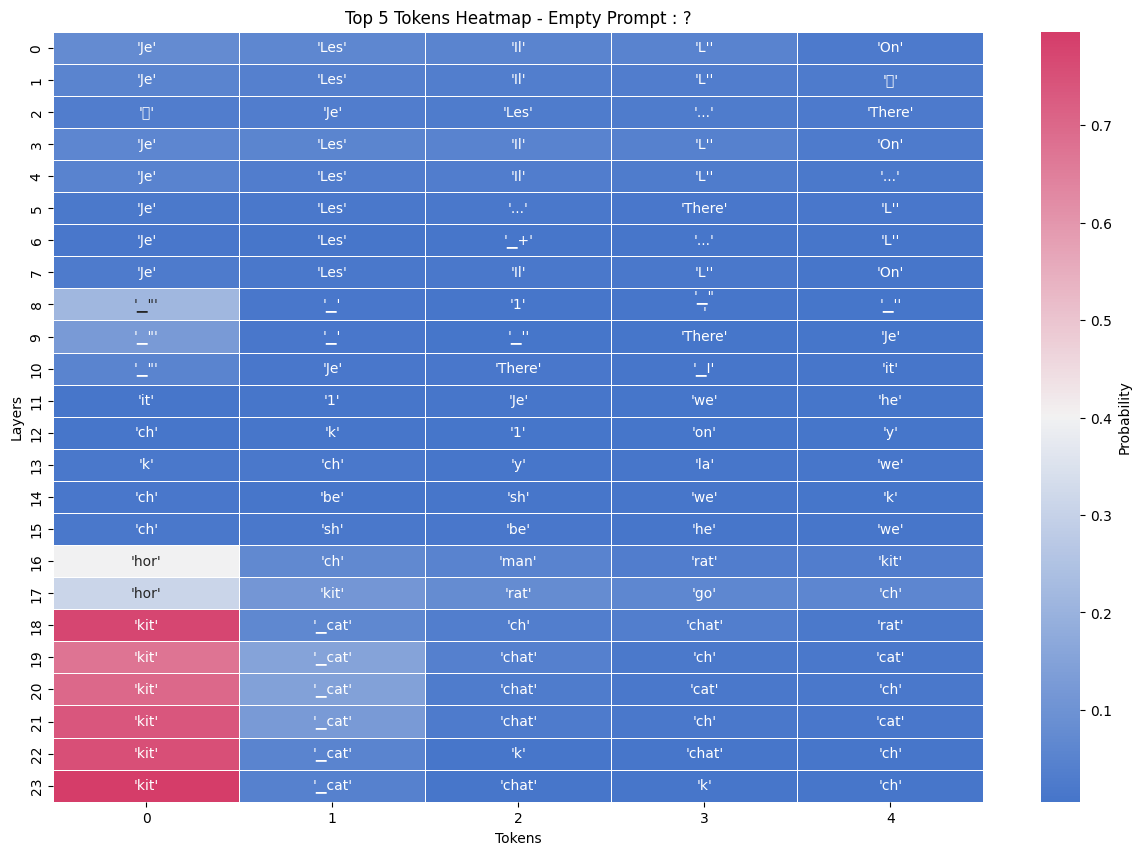

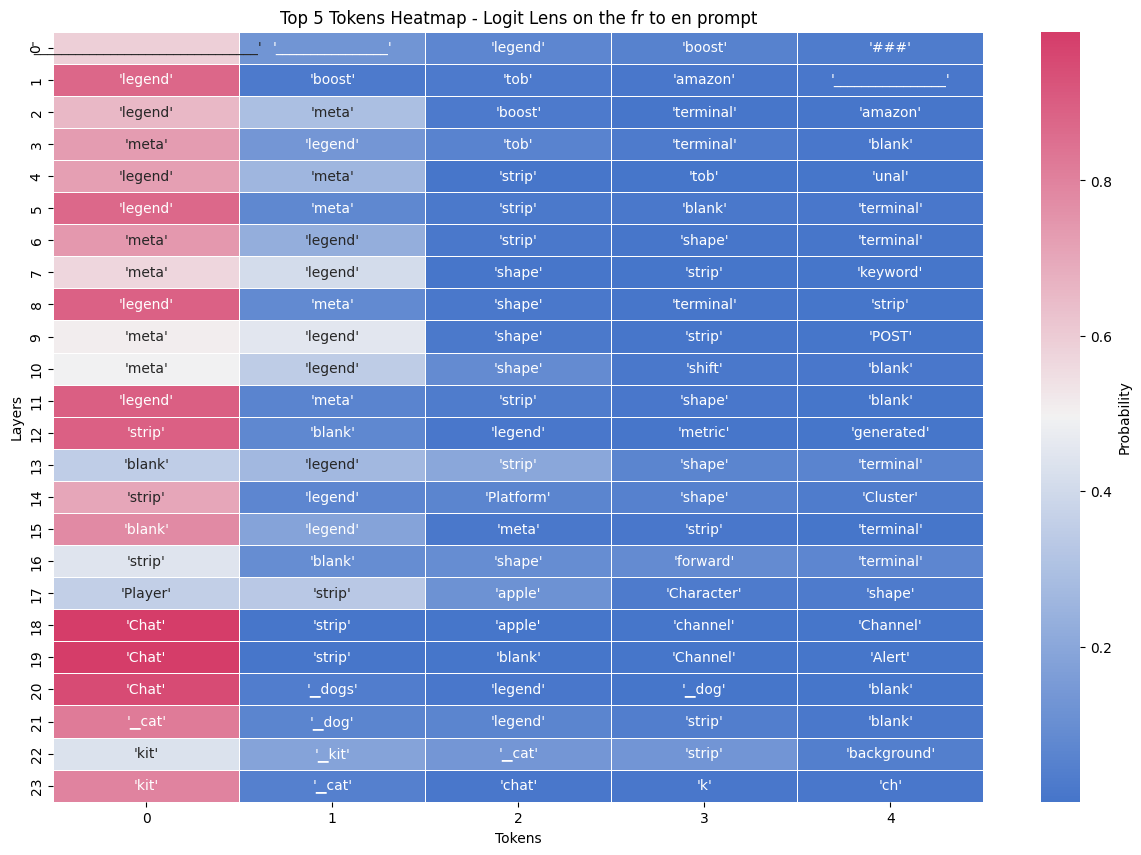

In [ ]:
plot_topk(
    empty_probs[0],
    nn_model,
    k=5,
    title=f"Empty Prompt : {empty_prompt.prompt}",
    dynamic_size=0,
)
plot_topk(
    llens_probs[0],
    nn_model,
    k=5,
    title="Logit Lens on the fr to en prompt",
    dynamic_size=0,
)